In [1]:
try:
    import secml
except ImportError:
    %pip install secml[foolbox]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.0/464.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.6 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
from torch import optim
from secml.ml.classifiers import CClassifierPyTorch

random_state = 999


# creation of the multiclass classifier
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


n_features = 2
n_classes = 3

# torch model creation
net = Net(n_features=n_features, n_classes=n_classes, n_hidden=100)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
clf = CClassifierPyTorch(model=net,
                         loss=loss_function,
                         optimizer=optimizer,
                         input_shape=(n_features,),
                         random_state=random_state)

2023-12-19 18:27:37,028 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data
2023-12-19 18:27:37,028 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data


INFO:secml.settings:New `SECML_HOME_DIR` created: /root/secml-data


2023-12-19 18:27:37,038 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf
2023-12-19 18:27:37,038 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf


INFO:secml.settings:Default configuration file copied to: /root/secml-data/secml.conf


2023-12-19 18:27:37,043 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets
2023-12-19 18:27:37,043 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets


INFO:secml.settings:New `SECML_DS_DIR` created: /root/secml-data/datasets


2023-12-19 18:27:37,047 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models
2023-12-19 18:27:37,047 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models


INFO:secml.settings:New `SECML_MODELS_DIR` created: /root/secml-data/models


2023-12-19 18:27:37,053 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments
2023-12-19 18:27:37,053 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments


INFO:secml.settings:New `SECML_EXP_DIR` created: /root/secml-data/experiments


2023-12-19 18:27:37,058 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs
2023-12-19 18:27:37,058 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs


INFO:secml.settings:New `SECML_LOGS_DIR` created: /root/secml-data/logs


2023-12-19 18:27:37,063 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data
2023-12-19 18:27:37,063 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


INFO:secml.settings:New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


In [3]:
n_features = 2  # number of features
n_samples = 1250  # number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # centers of the clusters
cluster_std = 0.8  # standard deviation of the clusters
n_classes = len(centers)  # number of classes

from secml.data.loader import CDLRandomBlobs

dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000  # number of training set samples
n_ts = 250  # number of test set samples

# split in training and test
from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

In [4]:
clf.fit(tr.X, tr.Y)
y_pred = clf.predict(ts.X)

from secml.ml.peval.metrics import CMetricAccuracy

accuracy = CMetricAccuracy().performance_score(y_true=ts.Y, y_pred=y_pred)
print("Accuracy on test set: {:.2%}".format(accuracy))


Accuracy on test set: 99.60%


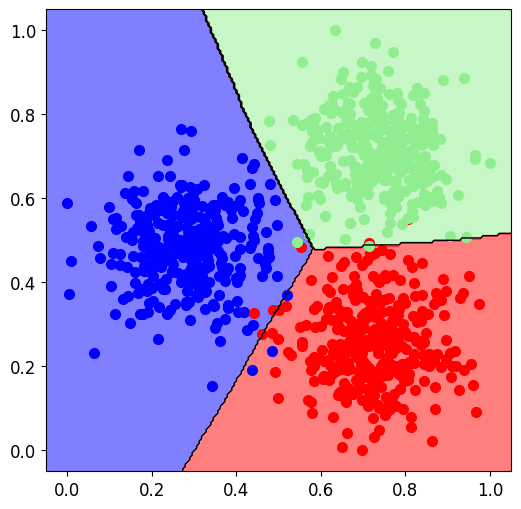

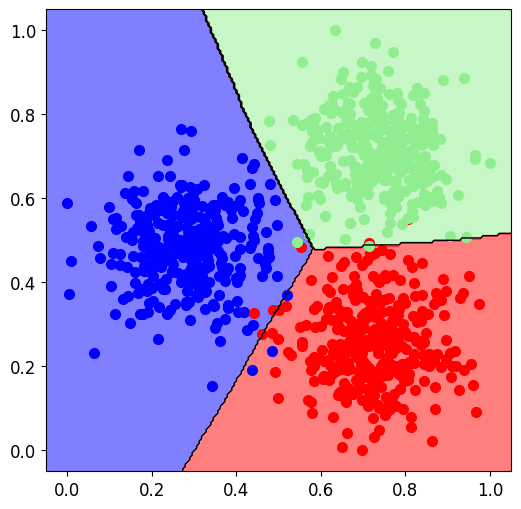

In [7]:
%matplotlib inline
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(tr)
fig.sp.plot_decision_regions(clf, plot_background=True, n_grid_points=200)
fig.show()

In [16]:
from secml.adv.attacks.evasion import CFoolboxPGDL2

y_target = None
index = 0
x0, y0 = ts.X[index, :], ts.Y[index]

# Attack parameters
lb = 0  # lower bound of the input space
ub = 1  # upper bound of the input space
epsilon = 0.03  # perturbation budget
abs_stepsize = 0.01  # stepsize of the attack
steps = 100  # number of iterations

pgd_attack = CFoolboxPGDL2(clf, None,
                           lb=lb, ub=ub,
                           epsilons=epsilon,
                           abs_stepsize=abs_stepsize,
                           steps=100,
                           random_start=False)

y_adv_pred, _, adv_ds_pgd, _ = pgd_attack.run(x0,y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-L2): ", y_adv_pred.item())

Original x0 label:  0
Adversarial example label (PGD-L2):  0


# Security Evaluations

Testing one single perturbation budget is not enough to understand the robustness of your machine learning classifier.
Hence, a fair analysis consists of a *security evaluation* of the model, by considering more perturbation budgets, and hence quantify the performance of the target systematically against stronger and stronger attacks.
To do so, we first set the number of parameters we want to test (in this case, `epsilons`) and we compute attacks by varying the perturbation size.

In [12]:
from secml.array import CArray
from secml.adv.attacks import CFoolboxPGDL2
from secml.ml.peval.metrics import CMetricAccuracy

epsilons = CArray.linspace(0,2,8) # create list of epsilons to use in the security evaluation
robust_accuracies = []
metric = CMetricAccuracy()
X, y = ts.X[:30, :], ts.Y[:30]

for eps in epsilons:
    pgd_attack = CFoolboxPGDL2(clf, None,
                           lb=0, ub=1,
                           epsilons=eps,
                           abs_stepsize=0.05,
                           steps=20,
                           random_start=False)
    y_adv_pred, _, _, _ = pgd_attack.run(X,y) # TODO: run the attack on the X, y set of samples
    accuracy = metric.performance_score(y, y_adv_pred)
    robust_accuracies.append(accuracy)

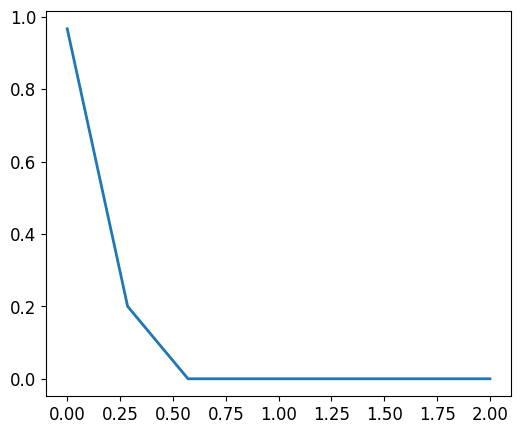

In [13]:
%matplotlib inline
fig = CFigure(height=5, width=6)
fig.sp.plot(epsilons, robust_accuracies)
fig.show()